# 🧠 Brain Tumor Classification V3 - OPTIMIZED

**Improvements over V2:**
- Stronger data augmentation
- Unfreeze more layers (40 instead of 20)
- Class weights to handle imbalance
- Longer training (more epochs)
- Better learning rate scheduling

**Target: 85-90% accuracy**

---
## Step 0: Set Working Directory

In [1]:
import os

TARGET_DIR = '/home/jovyan/work/cancer modele'

if os.path.exists(TARGET_DIR):
    os.chdir(TARGET_DIR)
    print(f"✅ Working directory: {os.getcwd()}")
else:
    print(f"⚠️ Directory not found: {TARGET_DIR}")

# Check for dataset
if os.path.exists('brain_tumor_dataset'):
    print("✅ Dataset found!")
else:
    print("❌ Dataset not found!")

✅ Working directory: /home/jovyan/work/cancer modele
✅ Dataset found!


---
## Step 1: Environment Setup & GPU Configuration

In [2]:
!pip install -q "numpy<2.0" kaggle tensorflow pandas matplotlib seaborn scikit-learn albumentations

import os
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import numpy as np

# Use single GPU with memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print(f"✅ Using GPU: {gpus[0].name}")
    except RuntimeError as e:
        print(f"⚠️ GPU config error: {e}")
else:
    print("⚠️ No GPU detected.")

print(f"📦 TensorFlow Version: {tf.__version__}")

2025-12-21 18:55:47.742715: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-21 18:55:47.879762: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-21 18:55:47.916069: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-21 18:55:48.690752: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

✅ Using GPU: /physical_device:GPU:0
📦 TensorFlow Version: 2.10.1


---
## Step 2: Import Libraries

In [3]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

print("✅ Libraries imported!")

✅ Libraries imported!


---
## Step 3: Dataset Setup

In [4]:
os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd()

TRAIN_DIR = 'brain_tumor_dataset/Training'
TEST_DIR = 'brain_tumor_dataset/Testing'

# Download if needed
if not os.path.exists('brain_tumor_dataset'):
    if os.path.exists('kaggle.json'):
        os.chmod('kaggle.json', 0o600)
        !kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
        !unzip -q brain-tumor-mri-dataset.zip -d brain_tumor_dataset
        print("✅ Dataset downloaded!")
    else:
        print("❌ Please upload kaggle.json!")

# Count images per class
print("\n📊 Dataset Distribution:")
class_counts = {}
for class_name in sorted(os.listdir(TRAIN_DIR)):
    class_path = os.path.join(TRAIN_DIR, class_name)
    if os.path.isdir(class_path):
        count = len(os.listdir(class_path))
        class_counts[class_name] = count
        print(f"  {class_name}: {count} images")


📊 Dataset Distribution:
  glioma: 1321 images
  meningioma: 1339 images
  notumor: 1595 images
  pituitary: 1457 images


---
## Step 4: ENHANCED Data Augmentation & Generators

In [5]:
# Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

# STRONGER augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    # ENHANCED augmentation
    rotation_range=30,           # Increased from 15
    width_shift_range=0.2,       # Increased from 0.1
    height_shift_range=0.2,      # Increased from 0.1
    shear_range=0.15,            # NEW
    zoom_range=0.2,              # Increased from 0.1
    horizontal_flip=True,
    vertical_flip=True,          # NEW - brain scans can be flipped vertically
    brightness_range=[0.8, 1.2], # NEW - brightness variation
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load data
print("📥 Loading Training Data (80%)...")
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=SEED,
    shuffle=True
)

print("\n📥 Loading Validation Data (20%)...")
val_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=SEED,
    shuffle=False
)

print("\n📥 Loading Test Data...")
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

CLASS_NAMES = list(train_generator.class_indices.keys())
NUM_CLASSES = len(CLASS_NAMES)
print(f"\n✅ Classes: {CLASS_NAMES}")

📥 Loading Training Data (80%)...
Found 4571 images belonging to 4 classes.

📥 Loading Validation Data (20%)...
Found 1141 images belonging to 4 classes.

📥 Loading Test Data...
Found 1311 images belonging to 4 classes.

✅ Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


---
## Step 5: Compute Class Weights (Handle Imbalance)

In [6]:
# Compute class weights to handle imbalance
labels = train_generator.classes
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

class_weight_dict = dict(enumerate(class_weights_array))

print("⚖️ Class Weights (to balance training):")
for idx, name in enumerate(CLASS_NAMES):
    print(f"   {name}: {class_weight_dict[idx]:.4f}")

⚖️ Class Weights (to balance training):
   glioma: 1.0811
   meningioma: 1.0660
   notumor: 0.8956
   pituitary: 0.9801


---
## Step 6: Build IMPROVED ResNet50 Model

In [7]:
def build_improved_model(num_classes=4):
    """
    Build ResNet50 with IMPROVED classification head.
    - Added BatchNormalization
    - Larger Dense layer
    """
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )
    
    # Start with frozen backbone
    base_model.trainable = False
    
    # IMPROVED custom head
    x = base_model.output
    x = GlobalAveragePooling2D(name='avg_pool')(x)
    x = BatchNormalization()(x)          # NEW
    x = Dense(512, activation='relu')(x) # Increased from 256
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)          # NEW
    x = Dense(256, activation='relu')(x) # NEW layer
    x = Dropout(0.3)(x)
    predictions = Dense(num_classes, activation='softmax', name='predictions')(x)
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model, base_model

model, base_model = build_improved_model(num_classes=NUM_CLASSES)

print("🏗️ Model Built:")
print(f"   Total Parameters: {model.count_params():,}")
print(f"   Trainable Parameters: {sum([tf.keras.backend.count_params(w) for w in model.trainable_weights]):,}")

2025-12-21 18:55:51.489000: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-21 18:55:52.198579: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 44915 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:4b:00.0, compute capability: 8.6


🏗️ Model Built:
   Total Parameters: 24,779,396
   Trainable Parameters: 1,186,564


---
## Step 7: Define Callbacks

In [8]:
# Stage 1 callbacks
early_stop_1 = EarlyStopping(
    monitor='val_loss',
    patience=7,  # Increased from 5
    restore_best_weights=True,
    verbose=1
)

checkpoint_1 = ModelCheckpoint(
    'best_model_stage1.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-8,
    verbose=1
)

print("✅ Callbacks configured")

✅ Callbacks configured


---
## Step 8: Stage 1 — EXTENDED Warm-up Training

In [9]:
print("🚀 STAGE 1: Training Custom Head (EXTENDED)")
print("=" * 50)

base_model.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# EXTENDED: 15 epochs instead of 10
EPOCHS_STAGE1 = 15

history_stage1 = model.fit(
    train_generator,
    epochs=EPOCHS_STAGE1,
    validation_data=val_generator,
    class_weight=class_weight_dict,  # IMPORTANT: using class weights
    callbacks=[early_stop_1, checkpoint_1, reduce_lr],
    verbose=1
)

print(f"\n✅ Stage 1 Complete! Best Val Accuracy: {max(history_stage1.history['val_accuracy']):.4f}")

🚀 STAGE 1: Training Custom Head (EXTENDED)
Epoch 1/15


2025-12-21 18:55:58.169930: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8900


  1/143 [..............................] - ETA: 11:06 - loss: 2.1404 - accuracy: 0.2500

2025-12-21 18:55:59.461417: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


143/143 [==============================] - ETA: 0s - loss: 1.4477 - accuracy: 0.4095
Epoch 1: val_accuracy improved from -inf to 0.29097, saving model to best_model_stage1.keras
143/143 [==============================] - 66s 435ms/step - loss: 1.4477 - accuracy: 0.4095 - val_loss: 1.3912 - val_accuracy: 0.2910 - lr: 1.0000e-04
Epoch 2/15
143/143 [==============================] - ETA: 0s - loss: 1.2200 - accuracy: 0.4935
Epoch 2: val_accuracy improved from 0.29097 to 0.30061, saving model to best_model_stage1.keras
143/143 [==============================] - 61s 426ms/step - loss: 1.2200 - accuracy: 0.4935 - val_loss: 1.3481 - val_accuracy: 0.3006 - lr: 1.0000e-04
Epoch 3/15
143/143 [==============================] - ETA: 0s - loss: 1.1623 - accuracy: 0.5106
Epoch 3: val_accuracy improved from 0.30061 to 0.48203, saving model to best_model_stage1.keras
143/143 [==============================] - 63s 439ms/step - loss: 1.1623 - accuracy: 0.5106 - val_loss: 1.2036 - val_accuracy: 0.4820 - 

---
## Step 9: Stage 2 — DEEPER Fine-tuning

In [10]:
print("🔥 STAGE 2: Fine-tuning (DEEPER - Unfreezing 40 layers)")
print("=" * 50)

# Unfreeze MORE layers (40 instead of 20)
base_model.trainable = True
FREEZE_UNTIL = len(base_model.layers) - 40  # Changed from 20 to 40
for layer in base_model.layers[:FREEZE_UNTIL]:
    layer.trainable = False

trainable_count = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
print(f"\n📊 Trainable parameters: {trainable_count:,}")

# Re-compile with VERY low learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Stage 2 callbacks
early_stop_2 = EarlyStopping(
    monitor='val_loss',
    patience=10,  # More patience for fine-tuning
    restore_best_weights=True,
    verbose=1
)

checkpoint_2 = ModelCheckpoint(
    'best_model_v3_finetuned.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

# EXTENDED: 30 epochs instead of 20
EPOCHS_STAGE2 = 30

history_stage2 = model.fit(
    train_generator,
    epochs=EPOCHS_STAGE2,
    validation_data=val_generator,
    class_weight=class_weight_dict,  # Still using class weights
    callbacks=[early_stop_2, checkpoint_2, reduce_lr],
    verbose=1
)

print(f"\n✅ Stage 2 Complete! Best Val Accuracy: {max(history_stage2.history['val_accuracy']):.4f}")

🔥 STAGE 2: Fine-tuning (DEEPER - Unfreezing 40 layers)

📊 Trainable parameters: 17,018,372
Epoch 1/30
143/143 [==============================] - ETA: 0s - loss: 1.2455 - accuracy: 0.4590
Epoch 1: val_accuracy improved from -inf to 0.30324, saving model to best_model_v3_finetuned.keras
143/143 [==============================] - 67s 446ms/step - loss: 1.2455 - accuracy: 0.4590 - val_loss: 1.7394 - val_accuracy: 0.3032 - lr: 1.0000e-05
Epoch 2/30
143/143 [==============================] - ETA: 0s - loss: 1.0989 - accuracy: 0.5307
Epoch 2: val_accuracy improved from 0.30324 to 0.53725, saving model to best_model_v3_finetuned.keras
143/143 [==============================] - 59s 413ms/step - loss: 1.0989 - accuracy: 0.5307 - val_loss: 1.1449 - val_accuracy: 0.5372 - lr: 1.0000e-05
Epoch 3/30
143/143 [==============================] - ETA: 0s - loss: 1.0754 - accuracy: 0.5366
Epoch 3: val_accuracy did not improve from 0.53725
143/143 [==============================] - 61s 424ms/step - loss: 1

---
## Step 10: Training History

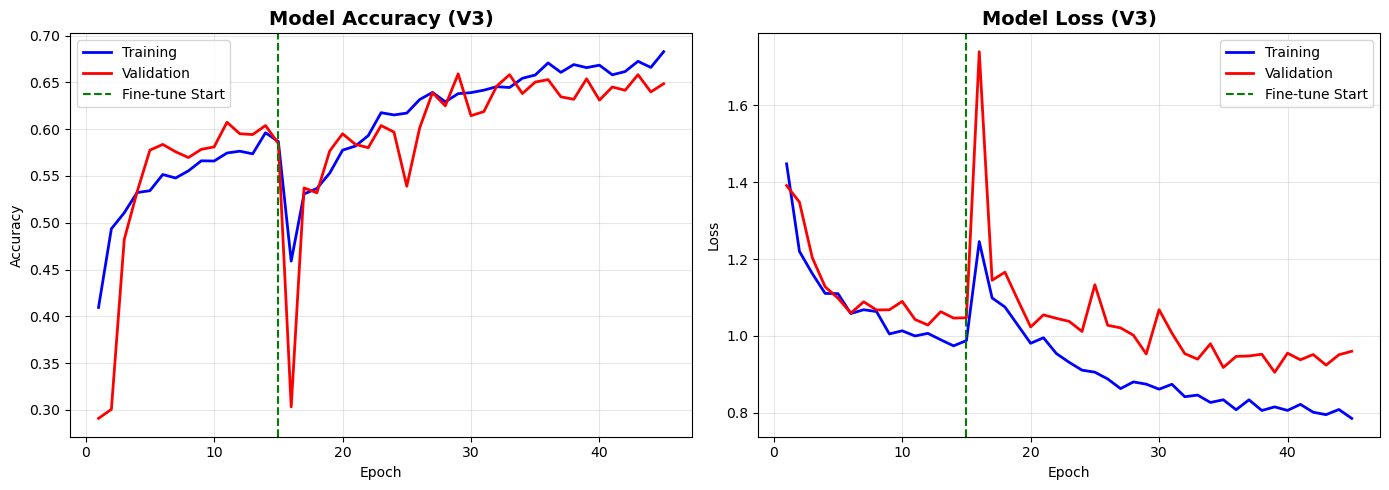

In [11]:
def plot_training_history(history1, history2):
    acc = history1.history['accuracy'] + history2.history['accuracy']
    val_acc = history1.history['val_accuracy'] + history2.history['val_accuracy']
    loss = history1.history['loss'] + history2.history['loss']
    val_loss = history1.history['val_loss'] + history2.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    stage1_end = len(history1.history['accuracy'])
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    axes[0].plot(epochs, acc, 'b-', label='Training', linewidth=2)
    axes[0].plot(epochs, val_acc, 'r-', label='Validation', linewidth=2)
    axes[0].axvline(x=stage1_end, color='green', linestyle='--', label='Fine-tune Start')
    axes[0].set_title('Model Accuracy (V3)', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(epochs, loss, 'b-', label='Training', linewidth=2)
    axes[1].plot(epochs, val_loss, 'r-', label='Validation', linewidth=2)
    axes[1].axvline(x=stage1_end, color='green', linestyle='--', label='Fine-tune Start')
    axes[1].set_title('Model Loss (V3)', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('training_history_v3.png', dpi=150)
    plt.show()

plot_training_history(history_stage1, history_stage2)

---
## Step 11: Model Evaluation

In [12]:
print("📊 EVALUATING MODEL V3 ON TEST SET")
print("=" * 50)

from tensorflow.keras.models import load_model

best_model_path = 'best_model_v3_finetuned.keras'
if os.path.exists(best_model_path):
    model = load_model(best_model_path)
    print(f"✅ Loaded: {best_model_path}")

test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
print(f"\n🎯 Test Loss: {test_loss:.4f}")
print(f"🎯 Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Predictions
test_generator.reset()
predictions = model.predict(test_generator, verbose=1)
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

print("\n" + "=" * 50)
print("📋 CLASSIFICATION REPORT")
print("=" * 50)
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))

📊 EVALUATING MODEL V3 ON TEST SET
✅ Loaded: best_model_v3_finetuned.keras

🎯 Test Loss: 0.8718
🎯 Test Accuracy: 0.6888 (68.88%)
41/41 [==============================] - 4s 75ms/step

📋 CLASSIFICATION REPORT
              precision    recall  f1-score   support

      glioma     0.7852    0.3900    0.5212       300
  meningioma     0.5398    0.3987    0.4586       306
     notumor     0.8099    0.9259    0.8641       405
   pituitary     0.6110    0.9633    0.7477       300

    accuracy                         0.6888      1311
   macro avg     0.6865    0.6695    0.6479      1311
weighted avg     0.6957    0.6888    0.6643      1311



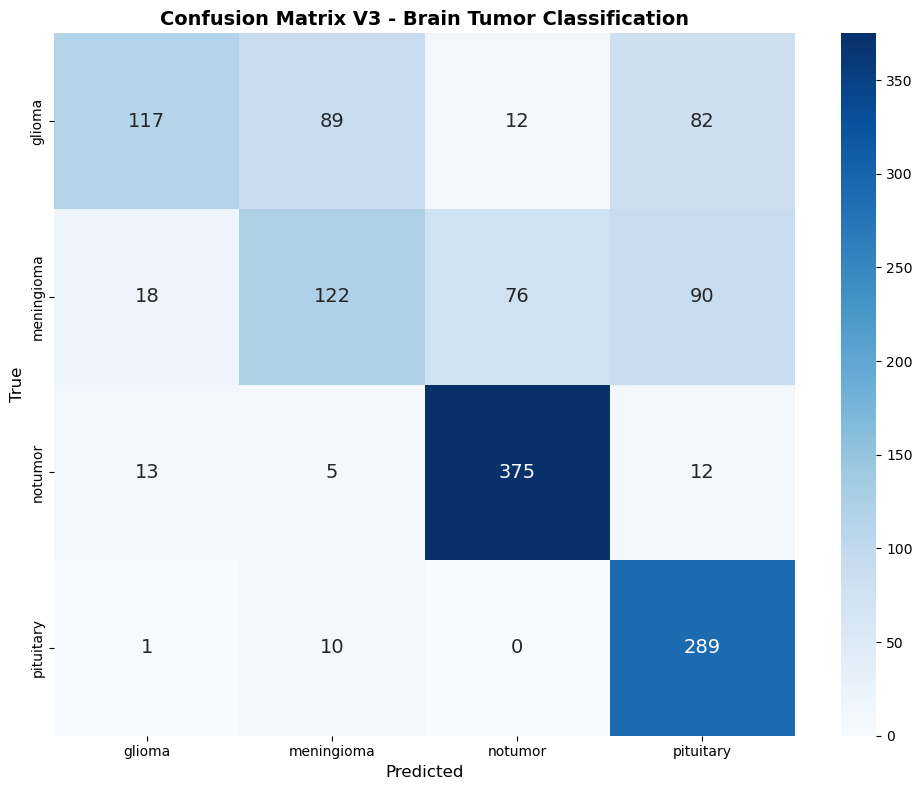

In [13]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=CLASS_NAMES,
    yticklabels=CLASS_NAMES,
    annot_kws={'size': 14}
)
plt.title('Confusion Matrix V3 - Brain Tumor Classification', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix_v3.png', dpi=150)
plt.show()

---
## Step 12: Save Final Model

In [14]:
FINAL_MODEL_PATH = 'brain_tumor_resnet50_v3_final.keras'
model.save(FINAL_MODEL_PATH)
print(f"\n✅ Final model saved: {FINAL_MODEL_PATH}")

print("\n" + "=" * 50)
print("📁 SAVED FILES")
print("=" * 50)
for f in ['best_model_stage1.keras', 'best_model_v3_finetuned.keras', 
          'brain_tumor_resnet50_v3_final.keras', 'training_history_v3.png', 
          'confusion_matrix_v3.png']:
    if os.path.exists(f):
        size_mb = os.path.getsize(f) / (1024 * 1024)
        print(f"  ✅ {f} ({size_mb:.2f} MB)")


✅ Final model saved: brain_tumor_resnet50_v3_final.keras

📁 SAVED FILES
  ✅ best_model_stage1.keras (104.11 MB)
  ✅ best_model_v3_finetuned.keras (225.01 MB)
  ✅ brain_tumor_resnet50_v3_final.keras (225.01 MB)
  ✅ training_history_v3.png (0.12 MB)
  ✅ confusion_matrix_v3.png (0.07 MB)


---
## 📊 Sample Predictions

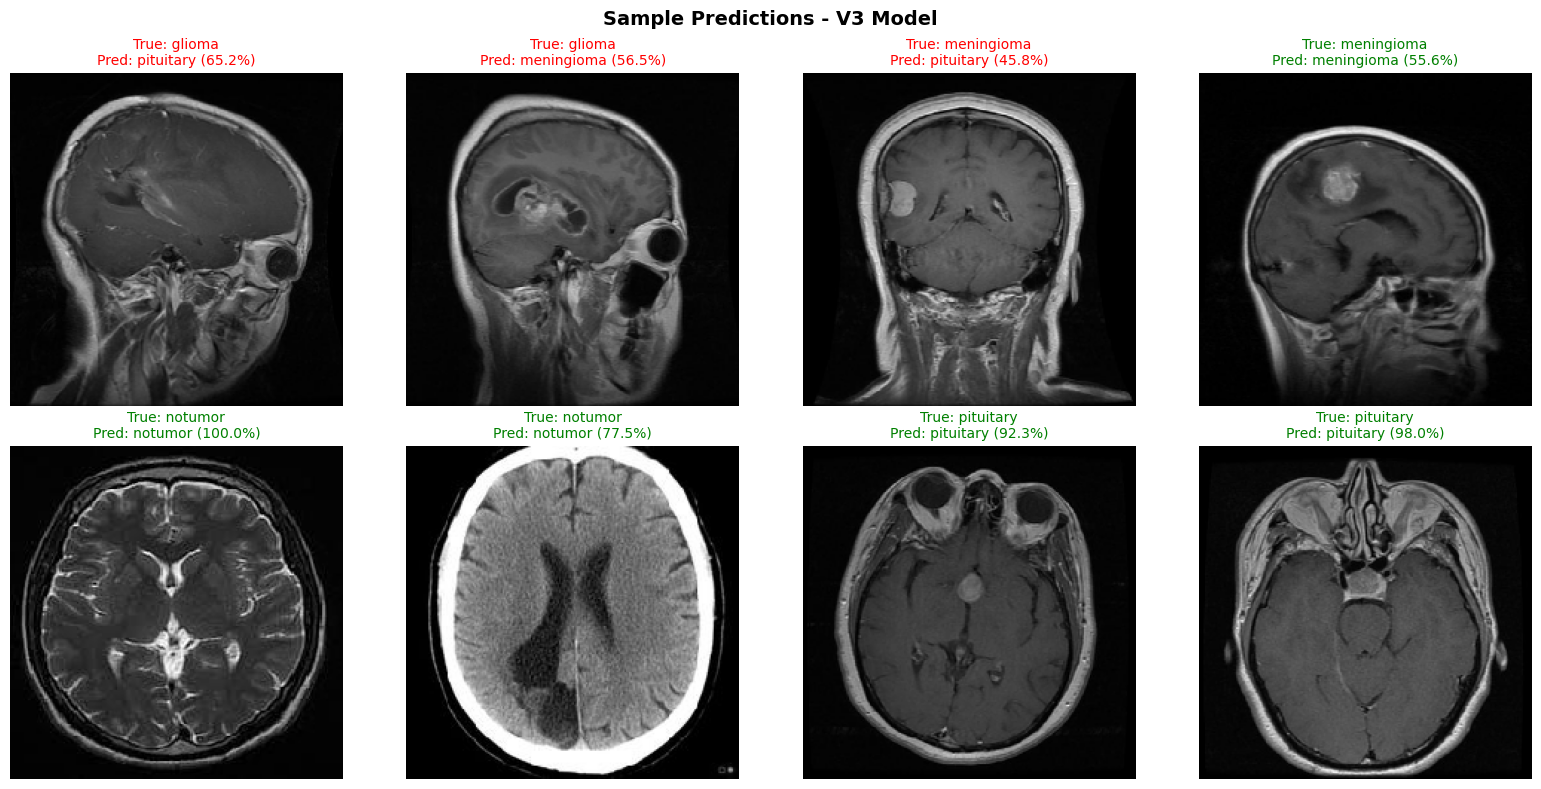


🎉 V3 Training Complete!


In [15]:
from tensorflow.keras.preprocessing import image

def predict_image(img_path, model, class_names):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    pred = model.predict(img_array, verbose=0)
    pred_class = class_names[np.argmax(pred)]
    confidence = np.max(pred) * 100
    
    return pred_class, confidence, img

# Sample predictions
test_images = []
for class_name in CLASS_NAMES:
    class_dir = os.path.join(TEST_DIR, class_name)
    images = os.listdir(class_dir)[:2]
    for img_name in images:
        test_images.append((os.path.join(class_dir, img_name), class_name))

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for idx, (img_path, true_label) in enumerate(test_images[:8]):
    pred_class, confidence, img = predict_image(img_path, model, CLASS_NAMES)
    
    axes[idx].imshow(img)
    color = 'green' if pred_class == true_label else 'red'
    axes[idx].set_title(f"True: {true_label}\nPred: {pred_class} ({confidence:.1f}%)", 
                        color=color, fontsize=10)
    axes[idx].axis('off')

plt.suptitle('Sample Predictions - V3 Model', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('sample_predictions_v3.png', dpi=150)
plt.show()

print("\n🎉 V3 Training Complete!")